In [1]:

import findspark
findspark.init()
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import CountVectorizer
import pandas as pd
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as fn

from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
import requests
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.streaming import StreamingContext

sc = SparkContext()
sqlContext = SQLContext(sc)
ssc = StreamingContext(sc, 10)#.getOrCreate()

stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
# github.com/daniel-acuna/python data science intro/tree/master/data -->dataset
tweet_df = sqlContext.read.parquet('./training_set/TrainTweet.parquet')



In [2]:
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("token")


stop_w_remover = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("token")\
  .setOutputCol("FilteredTweet")

vec = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("FilteredTweet")\
  .setOutputCol("tf")

pipeline = Pipeline(stages=[tokenizer, stop_w_remover, vec]).fit(tweet_df)

In [3]:
idf = IDF().setInputCol('tf').setOutputCol('idf')

pipeline_2 = Pipeline(stages=[pipeline, idf]).fit(tweet_df)
idf_df = pipeline_2.transform(tweet_df)

In [4]:
from  pyspark.sql.functions import *
print('Count Occurencies of words in the training set')
occurencies_df =  idf_df.select(concat_ws(' ', idf_df.FilteredTweet).alias('CleanString'))

count_occ_df = occurencies_df.withColumn('Occurencies', explode(split(col('CleanString'), ' ')))\
    .groupBy('Occurencies')\
    .count()\
    .sort('count', ascending=False)
    

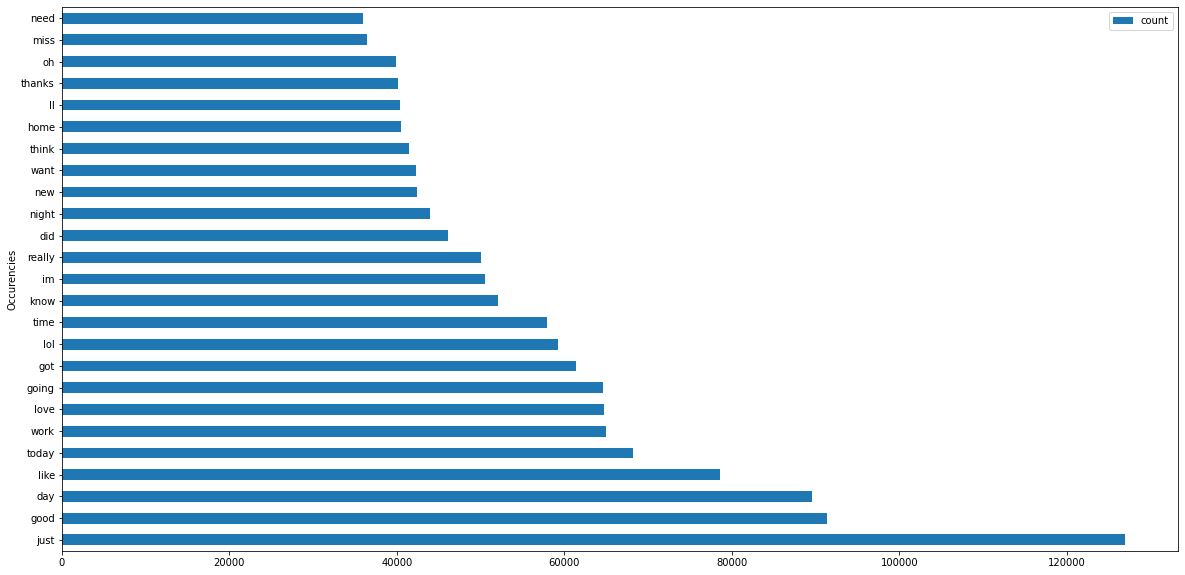

In [5]:
# to Pandas
pandas_count = count_occ_df.toPandas()
# Plot the 25 most frequent words
pandas_count.head(25).plot(kind='barh', x='Occurencies', y='count',figsize=(20,10) )

In [6]:
print('Split the dataset')
training_df, validation_df = tweet_df.randomSplit([0.7, 0.3], seed=87)

Split the dataset


In [7]:
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel
model = NaiveBayes().\
    setLabelCol('Class').\
    setFeaturesCol('idf')

model_pipeline = Pipeline(stages=[pipeline_2, model]).fit(training_df)


In [8]:
print('Validate the trained model')
model_pipeline.transform(validation_df).\
    select(fn.expr('float(prediction = Class)').alias('correct')).\
    select(fn.avg('correct')).show()


Validate the trained model
+------------------+
|      avg(correct)|
+------------------+
|0.7503961288683728|
+------------------+



In [10]:
print('Save model')
model_pipeline.save('./trained_model/')

Save model
